## NEMO Example 

For this example, the NEMO output files have already been saved as netCDF with the right coordinte names. The [xorca](https://github.com/willirath/xorca) package is designed to open NEMO datasets so they are understandable by xgcm. The [xnemogcm](https://github.com/rcaneill/xnemogcm) does a similar work on idealized configurations.

Below are some example of how to make calculations datasets using xgcm.

First we import xarray and xgcm:

In [1]:
import xarray as xr
import numpy as np
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (6,10)

Now we open the NEMO example dataset, from the BASIN configuration. The *ds* dataset contains the variables data (e.g. temperature, velocities) while the *domcfg* dataset contains the grid data (position, scale factor, etc).

We get the data from the website blablabla.

In [2]:
# download the data
import urllib.request
import shutil
url = 'https://rcaneill.pythonanywhere.com/'
file_name_domcfg = 'xnemogcm.domcfg.nc'
with urllib.request.urlopen(url + file_name_domcfg) as response, open(file_name_domcfg, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
file_name_basin = 'xnemogcm.nemo.nc'
with urllib.request.urlopen(url + file_name_basin) as response, open(file_name_basin, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    
# open the data
ds = xr.open_dataset(file_name_basin)
domcfg = xr.open_dataset(file_name_domcfg)

print('ds\n', ds)
print('\ndomcfg\n', domcfg)

ds
 <xarray.Dataset>
Dimensions:        (axis_nbounds: 2, t: 1, x_c: 21, x_f: 21, y_c: 40, y_f: 40, z_c: 36, z_f: 36)
Coordinates:
  * z_f            (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 31.5 32.5 33.5 34.5
  * t              (t) object 7756-01-01 00:00:00
  * x_c            (x_c) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19 20
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35
  * x_f            (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 17.5 18.5 19.5 20.5
  * y_f            (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 36.5 37.5 38.5 39.5
Dimensions without coordinates: axis_nbounds
Data variables:
    depthw_bounds  (z_f, axis_nbounds) float32 ...
    t_bounds       (t, axis_nbounds) object ...
    woce           (t, z_f, y_c, x_c) float32 ...
    e3w            (t, z_f, y_c, x_c) float32 ...
    deptht_bounds  (z_c, axis_nbounds) float32 ...
    e3t            (t, z_c, y_c, x_c

### Creating the grid object

Next we create a `Grid` object from the dataset.
All the axes are here non-periodic.
The `metrics` dict contains the scale factors.

In [3]:

metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0', 'e3uw_0', 'e3vw_0'], # Z distances
    #('X', 'Y'): [] # Areas TODO
}
grid = xgcm.Grid(domcfg, metrics=metrics, periodic=False)
print(grid)

<xgcm.Grid>
Y Axis (not periodic):
  * center   y_c --> right
  * right    y_f --> center
Z Axis (not periodic):
  * center   z_c --> left
  * left     z_f --> center
X Axis (not periodic):
  * center   x_c --> right
  * right    x_f --> center


We see that xgcm identified three different axes: X (longitude), Y (latitude), Z (depth).

### Horizontal gradient of SST

We will compute the horizontal component of the gradient of SST in the longitude
direction as a first example to understand the logic behind the
xgcm grids.

We want to compute
$\frac{\partial SST}{\partial x}$.
The SST is the variable `tos` (Temperature Ocean Surface) in our dataset.

In discrete form, using the NEMO notation, the derivative becomes

$$\frac{\partial SST}{\partial x} = \frac{1}{e_{1u}} \delta_{i+1/2} SST
= \frac{1}{e_{1u}} (SST_{i+1} - SST_i) \ .$$

The last T point is an earth point here, such as the 2 last U points: we set up the
`boundary` argument to 'fill' and the fill value to zero.

The gradient is first computed with the `diff` function and
then with the `gradient` function, the result is the same as the `gradient`
function is aware of which scale factor to use.

In [4]:
grad_T_lon0 = grid.diff(ds.tos, axis='X', boundary='fill', fill_value=0) / domcfg.e1u
grad_T_lon1 = grid.derivative(ds.tos, axis='X', boundary='fill', fill_value=0)
print(grad_T_lon1.coords)
(grad_T_lon0 == grad_T_lon1).all()

Coordinates:
  * t        (t) object 7756-01-01 00:00:00
  * y_c      (y_c) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * x_f      (x_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 16.5 17.5 18.5 19.5 20.5


<xarray.DataArray ()>
array(True)

As expected the result of the 2 operations is the same.
The position of the derivative is now on the U point.

### Divergence Calculation

Here we show how to calculate the divergence of the volume transport.
The precise details of how to do this calculation are highly model- and configuration-dependent (e.g. free-surface vs. rigid lid, etc.)
In this very simple example, the flow is incompressible, without precipitations
or evaporation, satisfying the continuity equation

$$ \vec{\nabla} \cdot \vec{u} = 
  \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}
  + \frac{\partial w}{\partial z} = 0 \ .$$

In discrete form, using NEMO notation, the equation becomes

$$ \vec{\nabla} \cdot \vec{u} = \frac{1}{e_{1t}e_{2t}e_{3t}} \left[
  \delta_i(u \cdot e_{2u} \cdot e_{3u})
  + \delta_j(v \cdot e_{1v} \cdot e_{3v})
  + \delta_k(w \cdot e_{1w} \cdot e_{2w}) \right] = 0 \ .$$

In this example, the grid is a Mercator grid, thus $e_{2t} = e_{2u} = e_{2v}$ and is
constant along the i-axis.
Moreover, the scale factors $e_1$ and $e_2$ are constant with depth, so
$e_{1w} = e_{1t}$ and $e_{2w} = e_{2t}$.
The equation can be rewritten as

$$ \vec{\nabla} \cdot \vec{u} = \frac{1}{e_{1t}} \delta_i(u) + 
  \frac{1}{e_{1t}e_{2t}e_{3t}} \delta_j(v \cdot e_{1v} \cdot e_{3v})
  + \frac{1}{e_{3t}} \delta_k{w} = 0\ .$$
  
*Remark:* as the grid width narrows towards the north, $e_{1t} \neq e_{1v}$.
The coordinate are terrain following, thus $e_{3t} \neq e_{3v}$.

First we calculate the divergence of the horizontal flow only (u and v), i.e. the first two terms on the LHS. To begin, we multiply the u and v velocity components by the appropriate area factors to convert them to volume transports.

In [32]:
#u_transport = ds.uVeltave * ds.dyG * ds.hFacW * ds.drF
#v_transport = ds.vVeltave * ds.dxG * ds.hFacS * ds.drF

The `u_transport` DataArray is on the left point of the X axis, while the `v_transport` DataArray is on the left point of the Y axis.

Now comes the xgcm magic: we take the diff along both axes and divide by the cell area element to find the divergence of the horizontal flow. Note how this new variable is at the cell center point.

In [31]:
#div_uv = (grid.diff(u_transport, 'X') + grid.diff(v_transport, 'Y'))
#div_uv

To verify that this worked properly, we can compute the vertical sum of the horizontal convergence.
It should be equal to the vertical velocity at the top.

In [33]:
#(-div_uv.sum(dim='Z') / ds.rA).plot();

In [34]:
#ds.wVeltave[0,0].plot();

Indeed these two fields look visually identical, which we can verify with a scatter plot.

In [35]:
#plt.scatter((-div_uv.sum(dim='Z') / ds.rA), ds.wVeltave[0,0], s=1)
#plt.ylim([-1e-7, 1e-7])
#plt.xlim([-1e-7, 1e-7])
#plt.grid()

Finally, we can compute the full 3D divergence by including the vertical transport.

In [36]:
#w_transport = ds.wVeltave * ds.rA
#div_w = -grid.diff(w_transport, 'Z', boundary='fill')
#div_w

Another scatterplot shows that the divergence of the horizontal velocity is equal and opposite to the divergence of the vertical velocity.

In [37]:
#plt.scatter(div_uv, -div_w, s=1)
#plt.grid()

### Vorticity and Strain
Here we compute more dervied quantities from the velocity field.

The vertical component of the vorticity is a fundamental quantity of interest in ocean circulation theory. It is defined as

$$ \zeta = - \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \ . $$

On the c-grid, a finite-volume representation is given by

$$ \zeta =  (- \delta_j \Delta x_c u + \delta_i \Delta y_c v ) / A_\zeta \ . $$

In xgcm, we calculate this quanity as

In [38]:
#zeta = (-grid.diff(ds.U * ds.dxC, 'Y') + grid.diff(ds.V * ds.dyC, 'X'))/ds.rAz
#zeta

...which we can see is located at the `YG, XG` horizontal position (also commonly called the vorticity point).

We plot the vertical integral of this quantity, i.e. the barotropic vorticity:

In [39]:
#zeta_bt = (zeta * ds.drF).sum(dim='Z')
#zeta_bt.plot(vmax=2e-4)

A different way to calculate the barotropic vorticity is to take the curl of the vertically integrated velocity.
This formulation also allows us to incorporate the $h$ factors representing partial cell thickness.

In [40]:
#u_bt = (ds.U * ds.hFacW * ds.drF).sum(dim='Z')
#v_bt = (ds.V * ds.hFacS * ds.drF).sum(dim='Z')
#zeta_bt_alt = (-grid.diff(u_bt * ds.dxC, 'Y') + grid.diff(v_bt * ds.dyC, 'X'))/ds.rAz
#zeta_bt_alt.plot(vmax=2e-4)

Another interesting quantity is the horizontal strain, defined as

$$ s = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y} \ . $$

On the c-grid, a finite-volume representation is given by

$$ s =  (\delta_i \Delta y_g u - \delta_j \Delta x_g v ) / A_c \ . $$

In [41]:
#strain = (grid.diff(ds.U * ds.dyG, 'X') - grid.diff(ds.V * ds.dxG, 'Y')) / ds.rA
#strain[0,0].plot()

### Barotropic Transport Streamfunction

We can use the barotropic velocity to calcuate the barotropic transport streamfunction, defined via

$$ u_{bt} = - \frac{\partial \Psi}{\partial y} \ , \ \ v_{bt} = \frac{\partial \Psi}{\partial x} \ .$$

$$ \Psi(x,y) = \int_0^x \int_{bottom}^{surface} v_{bt}(x,y) \, \text{d}z \, \text{d}x $$

We calculate this by integrating $v_{bt}$ along the X axis using the grid object's `integrate` method:

Coordinates:
  * t        (t) object 7756-01-01 00:00:00
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5
  * x_f      (x_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 16.5 17.5 18.5 19.5 20.5


(0, 60)

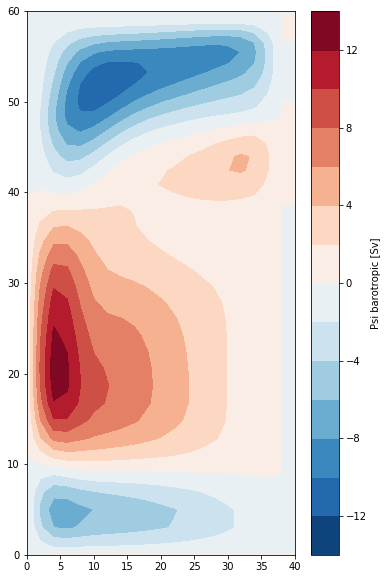

In [18]:
psi = grid.cumint(grid.integrate(ds.vo*ds.e3v/domcfg.e3v_0,'Z'),'X', boundary='fill') * 1e-6
print(psi.coords)
plt.contourf(
    domcfg.glamf,
    domcfg.gphif,
    psi.isel({'t':0}),
    levels=np.linspace(-14,14,15),
    cmap='RdBu_r'
)
plt.colorbar(label='Psi barotropic [Sv]')
plt.ylim(0,60)

<xarray.DataArray ()>
array(13.1183159)

We see that xgcm automatically shifted the Y-axis position from center (YC) to left (YG) during the cumsum operation.

We convert to sverdrups and plot with a contour plot.

### Kinetic Energy

Finally, we plot the kinetic energy $1/2 (u^2 + v^2)$ by interpoloting both quantities the cell center point.

In [10]:
# an example of calculating kinetic energy
#ke = 0.5*(grid.interp((ds.U*ds.hFacW)**2, 'X') + grid.interp((ds.V*ds.hFacS)**2, 'Y'))
#ke[0,0].plot()